In [ ]:
# Shivansh Chaturvedi
# GR5074 - Advanced Projects in Machine Learning 
# Homework 2

# GitHub Repo: https://github.com/shivansh-chaturvedi/GR5074-Advanced-Machine-Learning

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

# Assignment #1: Write up a report that makes use of Covid Positive X-Ray image data.

Imports and setting up data

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

from mpl_toolkits.axes_grid1 import ImageGrid
import random

import sys
import time
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

import aimodelshare as ai

In [ ]:
! pip install aimodelshare --upgrade

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

#### 1. Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

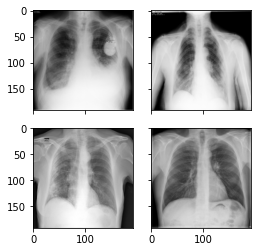

In [ ]:
# COVID patients

im1 = preprocessor(fnames[0][0])
im2 = preprocessor(fnames[0][1]) 
im3 = preprocessor(fnames[0][2]) 
im4 = preprocessor(fnames[0][3])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

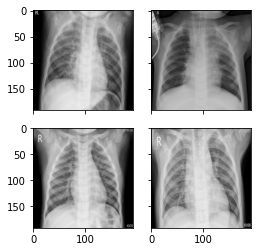

In [ ]:
# Pneumonia patients

im1 = preprocessor(fnames[2][0])
im2 = preprocessor(fnames[2][1]) 
im3 = preprocessor(fnames[2][2]) 
im4 = preprocessor(fnames[2][3])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

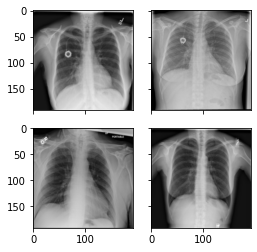

In [ ]:
# Not sick patients

im1 = preprocessor(fnames[1][0])
im2 = preprocessor(fnames[1][1]) 
im3 = preprocessor(fnames[1][2]) 
im4 = preprocessor(fnames[1][3])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

#### 2. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

The dataset has chest xrays of patients with COVID-19, pneumonia or healthy. The images are labeled to sort them into three groups. 

A prediction model on these images could help radiologists in their determinations of whether a patient has a disease and could help reduce times for patients to get results from their x-rays.

It would benefit hospitals, emergency centers, urgent cares, and patients.

#### 3. Run at least three prediction models to try to predict x-ray images well.

*   Use transfer learning for at least one of these models
*   Discuss which models performed better and point out relevant hyper-parameter values for successful models.
*   Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [ ]:
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
input_shape = list(X_train.shape)
print(input_shape)

[2741, 192, 192, 3]


In [ ]:
# Setup AI Model Share
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)


AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


#### Model 1: CNN, multiple layers

In [ ]:
# 5 layers 

model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 40, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 40, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 80, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 80, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(100, activation = 'relu'))

model.add(Dense(3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 1, verbose = 1, validation_split = 0.2)

69/69 [==============================] - 112s 2s/step - loss: 1.0924 - accuracy: 0.3581 - val_loss: 1.0865 - val_accuracy: 0.4335


In [ ]:
# 3 layers, 2 epochs

model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 40, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 80, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(100, activation = 'relu'))

model.add(Dense(3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 2, verbose = 1, validation_split = 0.2)

Epoch 1/2
69/69 [==============================] - 104s 2s/step - loss: 0.8875 - accuracy: 0.5926 - val_loss: 0.7942 - val_accuracy: 0.5537
Epoch 2/2
69/69 [==============================] - 108s 2s/step - loss: 0.6661 - accuracy: 0.6971 - val_loss: 0.8003 - val_accuracy: 0.5811


#### Model 2: Keras Neural Network

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 347s 5s/step - loss: 0.7368 - accuracy: 0.6720 - val_loss: 0.6685 - val_accuracy: 0.7158


In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                  

In [ ]:
ai.export_preprocessor(preprocessor,"")


Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 46s 1s/step


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): shivanshc, Team 3
Provide any useful notes about your model (optional): Team 3

Your model has been submitted as model version 443

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


#### Model 3: Transfer Learning

In [ ]:
base_model = VGG16(input_shape= (192, 192, 3), include_top=False, weights='imagenet')

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
#freeze VGG16 model weights
base_model.trainable = False
base_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
#New classifier layers
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(50, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

#model
tflearn_model = Model(inputs=base_model.inputs, outputs=output)
tflearn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
with tf.device('/device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)
  red_lr= ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.001)

  tflearn_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['acc']) 

  tflearn_model.fit(X_train, y_train, batch_size=1,
          epochs = 1, verbose = 1, validation_split = .2, callbacks = [mc, red_lr])

The TL model was very computationally expensive.

Based on the CNN Model, Keras NN Model and Transfer Learning model, we can see that the Keras NN model was the most appropriate, given its connected layer and the fact that it was able to run fairly computationally inexpensively.

#### 4. After you submit your first three models, describe your best model with your team via your team slack channel. Fit and submit up to three more models after learning from your team.


Conv1D model, 2 epochs

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D

model = Sequential()

model.add(Conv1D(filters = 20, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv1D(filters = 40, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv1D(filters = 80, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv1D(filters = 80, kernel_size = 2, padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(100, activation = 'relu'))

model.add(Dense(3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 2, verbose = 1, validation_split = 0.2)

Epoch 1/2
69/69 [==============================] - 82s 1s/step - loss: 1.0257 - accuracy: 0.5461 - val_loss: 0.9204 - val_accuracy: 0.5701
Epoch 2/2
69/69 [==============================] - 80s 1s/step - loss: 0.8146 - accuracy: 0.6419 - val_loss: 0.7619 - val_accuracy: 0.6357


Trying the Keras NN model with more layers

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 361s 5s/step - loss: 0.7491 - accuracy: 0.6620 - val_loss: 0.7250 - val_accuracy: 0.6922


In [ ]:
model.save("model.h5", save_format="h5")


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                 

In [ ]:
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model_knn = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model6.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

#### 4. Try to use augmented data to rerun at least one model and submit it to the leaderboard.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Let's try to mirror vertically
datagen = ImageDataGenerator(horizontal_flip=False, vertical_flip=True)


In [ ]:
aug_iter = datagen.flow(X_train, batch_size=1)

In [ ]:
modelv2 = model.fit(datagen.flow(X_train, y_train, batch_size = 1), epochs = 1)


In [ ]:
modelv2.save("modelv2.h5", save_format="h5")


In [ ]:
modelv2 = tf.keras.models.load_model('modelv2.h5',compile=False)
modelv2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
modelv2.summary()

In [ ]:
ai.export_preprocessor(preprocessor,"")


In [ ]:
onnx_modelv2 = model_to_onnx(modelv2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("modelv2.onnx", "wb") as f:
    f.write(onnx_model7.SerializeToString())

In [ ]:
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=modelv2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "modelv2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

#### 5. Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

Based on my models, the Keras Neural Network with additional layers performed best on thr leaderboard.